In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import utils #file located in same directory as this notebook that contains functions I created
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [2]:
covid_data = pd.read_csv('Data/CleanedCovidData10-16.csv')

### Inspecting Risk Factors
---

My initial thoughts are that certain risk factors such as "Obesity", "Smoker", "Pneumonia", etc. may play a role in whether or not a COVID patient dies. I will look at the death rate by risk factor.

In [3]:
#these files are required in order to do value mapping for the visualizations
with open('Data/post_cleaning_data_mapping.json') as json_file:
    mappings = json.load(json_file)

### Figure 1 in Report

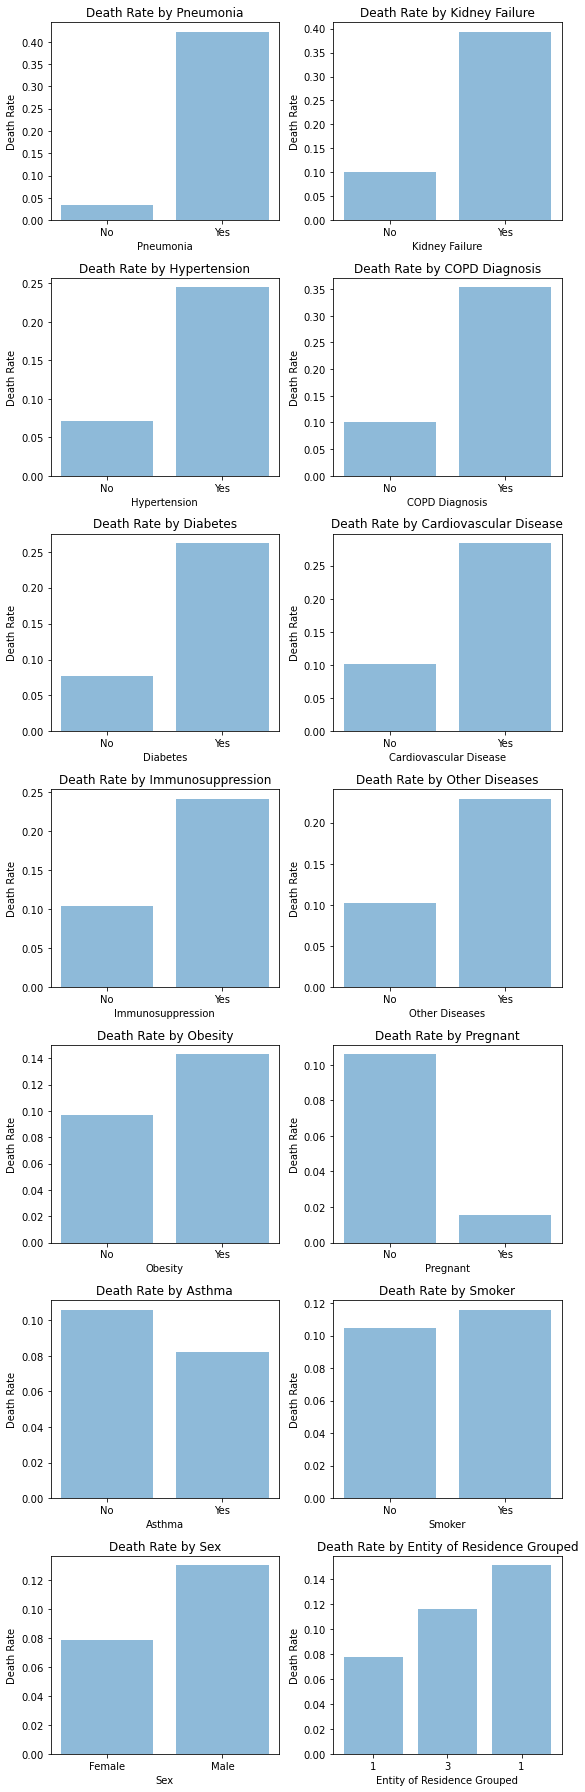

In [4]:
#plotting all the binary yes or no risk factors death rates in the same figure as well as Sex and Entity Location
fig,ax = plt.subplots(7,2)
fig.set_size_inches(8, 25)
ax[0,0] = utils.getDeathRates3(covid_data,'Pneumonia','Died',ax[0,0],mappings['Pneumonia'])
ax[0,1] = utils.getDeathRates3(covid_data,'Kidney Failure','Died',ax[0,1],mappings['Kidney Failure'])
ax[1,0] = utils.getDeathRates3(covid_data,'Hypertension','Died',ax[1,0],mappings['Hypertension'])
ax[1,1] = utils.getDeathRates3(covid_data,'COPD Diagnosis','Died',ax[1,1],mappings['COPD Diagnosis'])
ax[2,0] = utils.getDeathRates3(covid_data,'Diabetes','Died',ax[2,0],mappings['Diabetes'])
ax[2,1] = utils.getDeathRates3(covid_data,'Cardiovascular Disease','Died',ax[2,1],mappings['Cardiovascular Disease'])
ax[3,0] = utils.getDeathRates3(covid_data,'Immunosuppression','Died',ax[3,0],mappings['Immunosuppression'])
ax[3,1] = utils.getDeathRates3(covid_data,'Other Diseases','Died',ax[3,1],mappings['Other Diseases'])
ax[4,0] = utils.getDeathRates3(covid_data,'Obesity','Died',ax[4,0],mappings['Obesity'])
ax[4,1] = utils.getDeathRates3(covid_data,'Pregnant','Died',ax[4,1],mappings['Pregnant'])
ax[5,0] = utils.getDeathRates3(covid_data,'Asthma','Died',ax[5,0],mappings['Asthma'])
ax[5,1] = utils.getDeathRates3(covid_data,'Smoker','Died',ax[5,1],mappings['Smoker'])
ax[6,0] = utils.getDeathRates3(covid_data,'Sex','Died',ax[6,0],mappings['Sex'])
ax[6,1] = utils.getDeathRates3(covid_data,'Entity of Residence Grouped','Died',ax[6,1],mappings['Entity of Residence Grouped'])
fig.tight_layout()
#fig.savefig('Binary Variable Death Rates.png')

### Part of Figure  in Report 

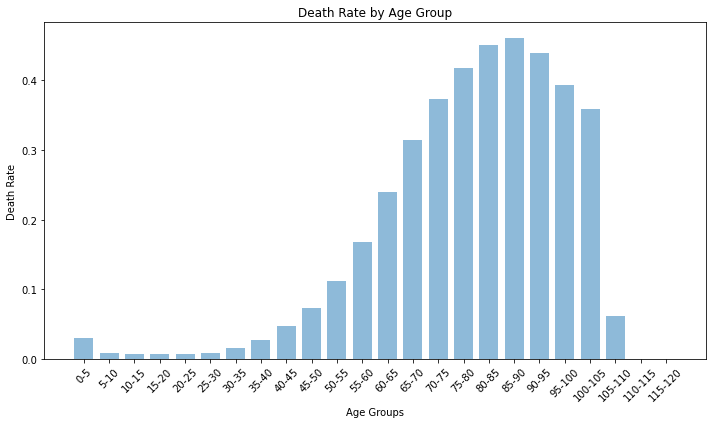

In [5]:
#plotting the death rates by age group (every 10 years)
gap = 5
death_rates = []
x_labs = []
x_labeling = []
for i in range(0,120,gap):
    subset = covid_data[covid_data['Age'].between(i,i+gap)]
    death_rates.append(sum(subset['Died'])/len(subset['Died']))
    x_labs.append((i+i+gap)/2)
    x_labeling.append(str(i)+"-"+str(i+gap))

fig,ax = plt.subplots(1)    
fig.set_size_inches(10, 6)
ax.bar(x_labs, death_rates, align='center', alpha=0.5,width=gap*3/4)
ax.set_xlabel('Age Groups')
ax.set_xticks(x_labs)
plt.xticks(rotation=45)
ax.set_xticklabels(x_labeling)
ax.set_ylabel('Death Rate')
ax.set_title('Death Rate by Age Group')
fig.tight_layout()
#fig.savefig('Age Rates.png')

## Creating new Age Feature
The pattern of death rate for different age groups doesn't follow closely to any pattern that I can think of. It certainly isn't linear from start to end. However, it does appear linear between the ages of 35 and 90. Before age 35, the death rate is mostly uniform with the exception of the 0-5 age group. After age 90, the death rate actually declines. I have a bias in thinking that being extra old doesn't give you an advantage when fighting COVID. My thoughts are that there are less observations in these age groups, and that this has not allowed their age groups death rates to become closer to their real estimated death rates. Therefore, I want to create a new age group that classifies all people under the age of 35 as being 35, since it appears as if their death rates are very close anyway. Then, for anybody over the age of 90, I want to classify them as being 90, since even though the death rates start to fall, I am biased in thinking they actually flat line after age 90.

In [6]:
#creating new age feature
upper_limit = 90
lower_limit = 30
new_ages = []
for i in covid_data['Age']:
    if i < lower_limit:
        new_ages.append(lower_limit)
    elif i > upper_limit:
        new_ages.append(upper_limit)
    else:
        new_ages.append(i)
covid_data['New Age'] = new_ages

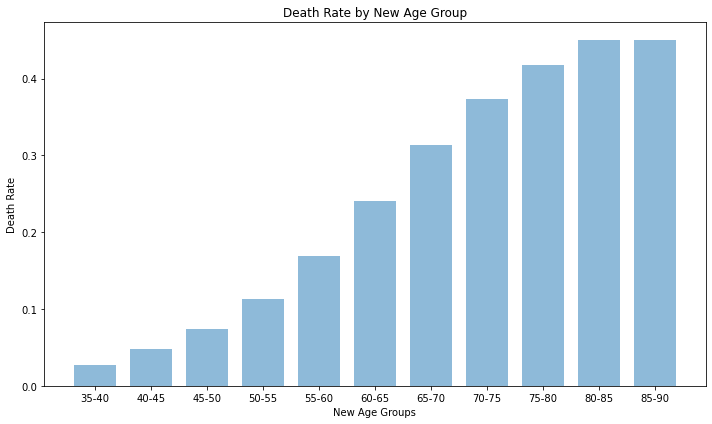

In [7]:
#plotting the death rates by the new age group (every 5 years)
gap = 5
death_rates = []
x_labs = []
x_labeling = []
for i in range(35,90,gap):
    subset = covid_data[covid_data['New Age'].between(i,i+gap)]
    death_rates.append(sum(subset['Died'])/len(subset['Died']))
    x_labs.append((i+i+gap)/2)
    x_labeling.append(str(i)+"-"+str(i+gap))

fig,ax = plt.subplots(1)    
fig.set_size_inches(10, 6)
ax.bar(x_labs, death_rates, align='center', alpha=0.5,width=gap*3/4)
ax.set_xlabel('New Age Groups')
ax.set_xticks(x_labs)
ax.set_xticklabels(x_labeling)
ax.set_ylabel('Death Rate')
ax.set_title('Death Rate by New Age Group')
fig.tight_layout()
#fig.savefig('New Age Rates.png')

This looks very linear now. I think that what I did is potentially putting bias into the data, but I think it should help the models later on perform much better since the ages will now match more to a distribution.

# Creating new Feature that sums number of conditions someone has

In [8]:
#creating list of factors to include in the sum and summing them
covid_data['Total Factors'] = covid_data[['Pneumonia','Diabetes','COPD Diagnosis','Asthma','Immunosuppression',
                                         'Hypertension','Other Diseases','Cardiovascular Disease','Obesity','Kidney Failure']].sum(axis=1)

Text(0.5, 1.0, 'Death Rate by Number of Factors Present')

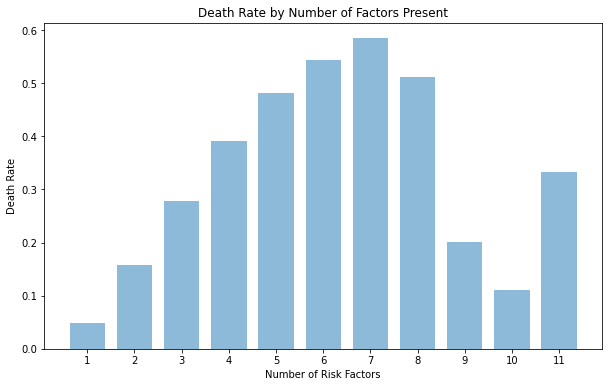

In [9]:
#plotting the death rates by total factors (every 1 factor)
gap = 1
death_rates = []
x_labs = []
x_labeling = []
for i in np.arange(0,11,gap):
    subset = covid_data[covid_data['Total Factors'].between(i,i+gap)]
    death_rates.append(sum(subset['Died'])/max(1,len(subset['Died'])))
    x_labs.append((i+i+gap)/2)
    x_labeling.append(str(i)+"-"+str(i+gap))

fig,ax = plt.subplots(1)    
fig.set_size_inches(10, 6)
ax.bar(range(1,12), death_rates, align='center', alpha=0.5,width=gap*3/4)
ax.set_xlabel('Number of Risk Factors')
ax.set_xticks(range(1,12))
ax.set_xticklabels(range(1,12))
ax.set_ylabel('Death Rate')
ax.set_title('Death Rate by Number of Factors Present')
#fig.savefig('Total Factors Rates.png')

# Before Exploring Interactions, I'd like to update the data file to have these two new features

In [10]:
covid_data.to_csv('Data/Post_Visualization_10-16.csv',index=False)

# Exploring Interactions

In [11]:
# First I need to encode the features
enc = OneHotEncoder()
enc.fit(covid_data[['Entity of Residence Grouped','Sex']])
encoded = enc.transform(covid_data[['Entity of Residence Grouped','Sex']]).toarray()

In [12]:
covid_data[list(enc.get_feature_names(['Entity Group','Sex']))] = encoded

In [13]:
del covid_data['Sex']
del covid_data['Entity of Residence Grouped']

In [14]:
#I am removing these features from the list to create interactions among. The reason is that Died is target variable, Age has
#been replaced by New Age, but I dont' want to get rid of the original Age in the data, and I don't want to look at interactions
#with location based features
cols = list(covid_data.columns)
cols.remove('Died')
cols.remove('Age')
cols.remove('Entity Group_1')
cols.remove('Entity Group_2')
cols.remove('Entity Group_3')

In [15]:
#I'm creating the interaction terms and then writing them to a dataframe and then finding out each of their 
#correlations with the target variable 'Died' so I can get an idea of which ones to test in the modeling file
poly_features = PolynomialFeatures(degree=2, interaction_only=True)
poly_features.fit(covid_data[cols])
interactions_data = poly_features.transform(covid_data[cols])
interaction_names = poly_features.get_feature_names(cols)
interactions_data = pd.DataFrame(interactions_data,columns=interaction_names)
correlations = interactions_data.corrwith(covid_data['Died'])
correlations.sort_values(ascending=False)[:50]

Pneumonia New Age                       0.533176
Pneumonia                               0.490899
Pneumonia Total Factors                 0.480568
New Age Total Factors                   0.439990
Total Factors                           0.395330
Pneumonia Sex_2                         0.394095
New Age                                 0.383009
Pneumonia Hypertension                  0.361682
Pneumonia Diabetes                      0.329490
Total Factors Sex_2                     0.317201
Hypertension Total Factors              0.289598
Diabetes Total Factors                  0.272099
Hypertension New Age                    0.261071
Pneumonia Sex_1                         0.254969
Diabetes New Age                        0.248028
Pneumonia Obesity                       0.236892
Hypertension                            0.222826
Diabetes                                0.218565
New Age Sex_2                           0.207014
Diabetes Hypertension                   0.202292
Hypertension Sex_2  

The above correlation listing shows the features and interactions most correlated with the target variable. I will consider all interactions with a correlation above 0.26 later in the modeling file.

In [16]:
#This shows the correlations between all of the risk factors since I am suspecting that there is collinearity in the data
covid_data[['Pneumonia','Pregnant','Diabetes','COPD Diagnosis','Asthma','Immunosuppression','Hypertension','Other Diseases',
           'Cardiovascular Disease','Obesity','Kidney Failure','Smoker']].corr()

,Pneumonia,Pregnant,Diabetes,COPD Diagnosis,Asthma,Immunosuppression,Hypertension,Other Diseases,Cardiovascular Disease,Obesity,Kidney Failure,Smoker
Pneumonia,1.000000,-0.019331,0.218480,0.085348,-0.011501,0.048507,0.203332,0.050243,0.074159,0.075989,0.099744,0.011375
Pregnant,-0.019331,1.000000,-0.028577,-0.009081,-0.002342,-0.000606,-0.036181,0.013331,-0.009211,-0.019611,-0.010143,-0.018302
Diabetes,0.218480,-0.028577,1.000000,0.083147,0.003108,0.049639,0.375544,0.032469,0.099436,0.103694,0.152789,0.007976
COPD Diagnosis,0.085348,-0.009081,0.083147,1.000000,0.037214,0.049335,0.102412,0.031484,0.092144,0.036022,0.052504,0.058722
Asthma,-0.011501,-0.002342,0.003108,0.037214,1.000000,0.021527,0.013126,0.013782,0.019198,0.042178,0.002406,0.003304
Immunosuppression,0.048507,-0.000606,0.049639,0.049335,0.021527,1.000000,0.038216,0.102438,0.054127,0.015521,0.095762,0.010862
Hypertension,0.203332,-0.036181,0.375544,0.102412,0.013126,0.038216,1.000000,0.051384,0.151755,0.153008,0.171496,0.002426
Other Diseases,0.050243,0.013331,0.032469,0.031484,0.013782,0.102438,0.051384,1.000000,0.062382,0.020041,0.047331,0.011785
Cardiovascular Disease,0.074159,-0.009211,0.099436,0.092144,0.019198,0.054127,0.151755,0.062382,1.000000,0.049884,0.093428,0.027300
Obesity,0.075989,-0.019611,0.103694,0.036022,0.042178,0.015521,0.153008,0.020041,0.049884,1.000000,0.009059,0.070515


The correlation matrix shows that:<br>
Pneumonia is correlated with quite a few other risk factors, such as Diabetes and Hypertension. <br>
Diabetes is correlated with Hypertension.<br>
Hypertension is correlated with Cardiovascular Disease.<br>
Obesity is correlated wtih Hypertension.<br>
Kidney Failure is correlated with Diabetes and Hypertension. <br>
This is all shown better in the shrunken correlation matrix below.

In [17]:
covid_data[['New Age','Pneumonia','Diabetes','Hypertension',
           'Cardiovascular Disease','Obesity','Kidney Failure']].corr()

,New Age,Pneumonia,Diabetes,Hypertension,Cardiovascular Disease,Obesity,Kidney Failure
New Age,1.000000,0.347417,0.344362,0.416245,0.142152,0.047360,0.096741
Pneumonia,0.347417,1.000000,0.218480,0.203332,0.074159,0.075989,0.099744
Diabetes,0.344362,0.218480,1.000000,0.375544,0.099436,0.103694,0.152789
Hypertension,0.416245,0.203332,0.375544,1.000000,0.151755,0.153008,0.171496
Cardiovascular Disease,0.142152,0.074159,0.099436,0.151755,1.000000,0.049884,0.093428
Obesity,0.047360,0.075989,0.103694,0.153008,0.049884,1.000000,0.009059
Kidney Failure,0.096741,0.099744,0.152789,0.171496,0.093428,0.009059,1.000000


### Entity of Residence Mappings

This is here to show which states are associated with which entity groupings.

#### Group 1

In [18]:
entity_map = mappings['Entity of Residence Grouped']
entity_nums = list(entity_map.keys())
entity_groups = list(entity_map.values())

group1 = []
group2 = []
group3 = []
for g in entity_groups:
    if g == 1:
        group1.append(True)
        group2.append(False)
        group3.append(False)
    elif g == 2:
        group1.append(False)
        group2.append(True)
        group3.append(False)
    else:
        group1.append(False)
        group2.append(False)
        group3.append(True)
entity_map = mappings['Entity of Residence']

In [19]:
print("Entities in Group 1 are:\n")
g1 = pd.Series(entity_nums)[group1]
for item in g1:
    print(entity_map[item])

Entities in Group 1 are:

BAJA CALIFORNIA SUR
DURANGO
COAHUILA DE ZARAGOZA
GUANAJUATO
SAN LUIS POTOSÍ
TAMAULIPAS
NUEVO LEÓN
CIUDAD DE MÉXICO
MICHOACÁN DE OCAMPO
AGUASCALIENTES
OAXACA
TABASCO
YUCATÁN


#### Group 2

In [20]:
print("Entities in Group 2 are:\n")
g2 = pd.Series(entity_nums)[group2]
for item in g2:
    print(entity_map[item])

Entities in Group 2 are:

ZACATECAS
QUERÉTARO
GUERRERO
COLIMA
JALISCO
SONORA
CHIHUAHUA
NAYARIT
PUEBLA


#### Group 3

In [21]:
print("Entities in Group 3 are:\n")
g3 = pd.Series(entity_nums)[group3]
for item in g3:
    print(entity_map[item])

Entities in Group 3 are:

VERACRUZ DE IGNACIO DE LA LLAVE
CAMPECHE
QUINTANA ROO
TLAXCALA
MÉXICO
HIDALGO
CHIAPAS
SINALOA
BAJA CALIFORNIA
MORELOS
